In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.layers import *
from keras.models import *
import scipy
import os
import glob
import cv2

import PIL
from tqdm import tqdm
import math, random
from sklearn.model_selection import *

from PIL import *
import sys
import warnings
import nibabel as nib
from scipy import ndimage
import matplotlib.pyplot as plt

In [2]:
adni = pd.read_csv('/kaggle/input/adni-process/data_path_adni_edited.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/adni-process/data_path_adni_edited.csv'

In [3]:
adni= adni.dropna(axis=0)
adni.shape

(643, 5)

In [4]:
print(adni['path'][0])
print(adni['mask_path'][0])
print(adni['processed_path'][0])

/kaggle/input/adni-1-5t-filtered-preprocessed-quickseg-dataset/MCI/I101411.nii/mri/orig/001.mgz
/kaggle/input/adni-1-5t-filtered-preprocessed-quickseg-dataset/MCI/I101411.nii/mri/mask.mgz
/kaggle/input/adni-1-5t-filtered-preprocessed-quickseg-dataset/MCI/I101411.nii/mri/orig.mgz


In [5]:
adni.isnull().sum()

path              0
label             0
study_id          0
mask_path         0
processed_path    0
dtype: int64

In [6]:
from tqdm import tqdm

(192, 192, 160)


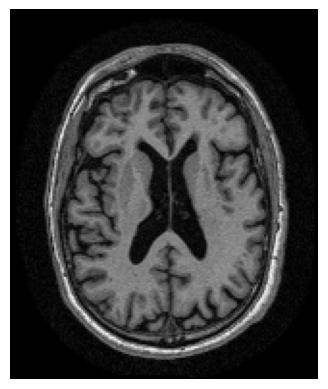

In [3]:
img_nifti = nib.load('/kaggle/input/adni-1-5t-filtered-preprocessed-quickseg-dataset/AD/I102040.nii/mri/orig/001.mgz')
img_data = img_nifti.get_fdata()
print(img_data.shape)



# Original image
plt.imshow(img_data[87, :, :], cmap='gray')
# plt.title(f'Original Image Size: {img_data.shape}')
plt.axis('off')
plt.show()

(192, 192, 160)


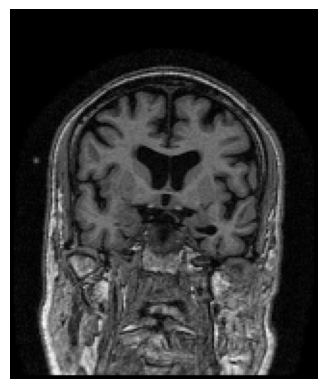

In [4]:
img_nifti = nib.load('/kaggle/input/adni-1-5t-filtered-preprocessed-quickseg-dataset/AD/I102040.nii/mri/orig/001.mgz')
img_data = img_nifti.get_fdata()
print(img_data.shape)



# Original image
plt.imshow(img_data[:, 87, :], cmap='gray')
# plt.title(f'Original Image Size: {img_data.shape}')
plt.axis('off')
plt.show()

(192, 192, 160)


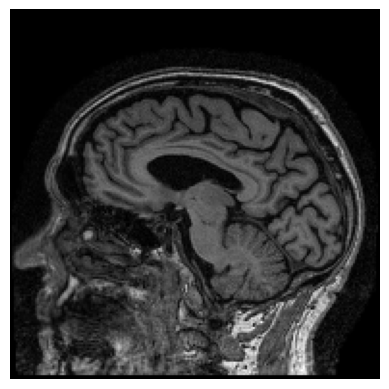

In [5]:
img_nifti = nib.load('/kaggle/input/adni-1-5t-filtered-preprocessed-quickseg-dataset/AD/I102040.nii/mri/orig/001.mgz')
img_data = img_nifti.get_fdata()
print(img_data.shape)



# Original image
plt.imshow(img_data[:, :, 87], cmap='gray')
# plt.title(f'Original Image Size: {img_data.shape}')
plt.axis('off')
plt.show()

(257, 257, 257)


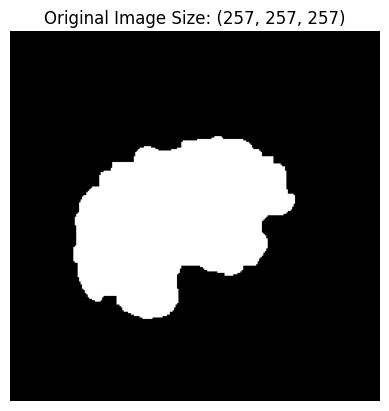

In [8]:
mask_nifti = nib.load(adni['mask_path'][125])
mask_data = mask_nifti.get_fdata()
print(mask_data.shape)



# Original image
plt.imshow(mask_data[87,: ,: ], cmap='gray')
plt.title(f'Original Image Size: {mask_data.shape}')
plt.axis('off')
plt.show()

In [9]:
mask_data[87, :, :]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

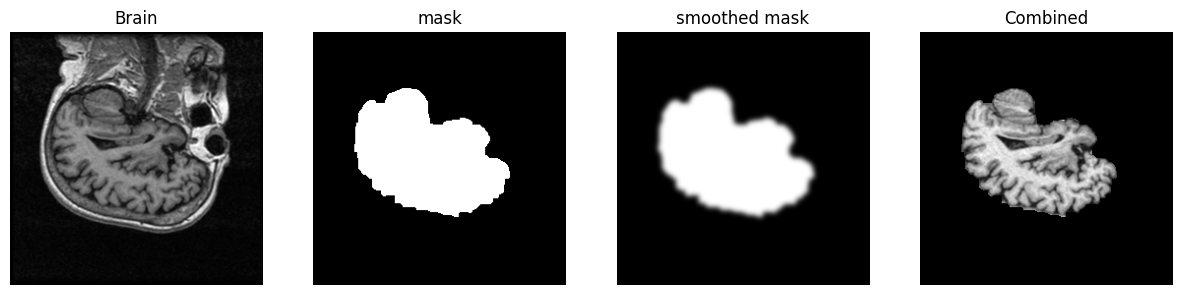

In [10]:
main_image = img_data[90,:, :]
mask_image = mask_data[90,:, :]


_, binary_mask = cv2.threshold(mask_image, 0, 1, cv2.THRESH_BINARY)
smoothed_mask = cv2.GaussianBlur(binary_mask.astype(np.float32), (15, 15), 0)
# Separate masked region
masked_region = main_image * binary_mask#smoothed_mask


fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Axial view
axs[0].imshow(main_image, cmap='gray', origin='lower')  # Transposed for proper orientation
axs[0].set_title('Brain')
axs[0].axis('off')

# Sagittal view
axs[1].imshow(mask_image, cmap='gray', origin='lower')  # Transposed for proper orientation
axs[1].set_title('mask')
axs[1].axis('off')

axs[2].imshow(smoothed_mask, cmap='gray', origin='lower')  # Transposed for proper orientation
axs[2].set_title('smoothed mask')
axs[2].axis('off')

# Coronal view
axs[3].imshow(masked_region, cmap='gray', origin='lower')  # Transposed for proper orientation
axs[3].set_title('Combined')
axs[3].axis('off')

plt.show()

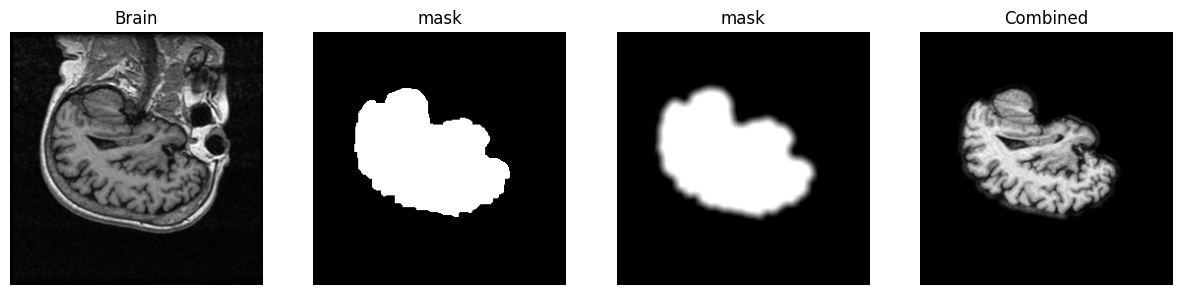

In [11]:


_, binary_mask = cv2.threshold(mask_image, 0, 1, cv2.THRESH_BINARY)
smoothed_mask = cv2.bilateralFilter(binary_mask.astype(np.float32), d=10, sigmaColor=75, sigmaSpace=75)

# Separate masked region
masked_region = main_image * smoothed_mask


fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Axial view
axs[0].imshow(main_image, cmap='gray', origin='lower')  # Transposed for proper orientation
axs[0].set_title('Brain')
axs[0].axis('off')

# Sagittal view
axs[1].imshow(mask_image, cmap='gray', origin='lower')  # Transposed for proper orientation
axs[1].set_title('mask')
axs[1].axis('off')

axs[2].imshow(smoothed_mask, cmap='gray', origin='lower')  # Transposed for proper orientation
axs[2].set_title('mask')
axs[2].axis('off')

# Coronal view
axs[3].imshow(masked_region, cmap='gray', origin='lower')  # Transposed for proper orientation
axs[3].set_title('Combined')
axs[3].axis('off')

plt.show()

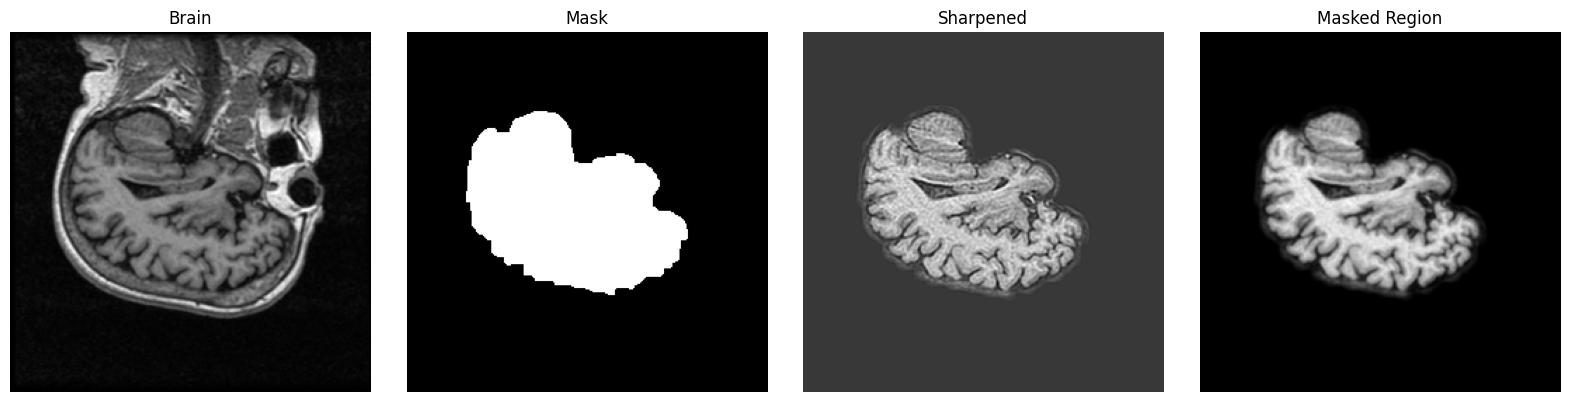

In [12]:


# kernel = np.array([[0, 0, 0],
#                    [-5, 20, -5],
#                    [0, 0, 0]])
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])

image_sharp_2d = cv2.filter2D(src=masked_region, ddepth=-1, kernel=kernel)
# image_sharp_2d = cv2.cvtColor(image_sharp_2d, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 4, figsize=(20, 8))

axs[0].imshow(main_image, cmap='gray', origin='lower')
axs[0].set_title('Brain')
axs[0].axis('off')

# Show the mask image
axs[1].imshow(mask_image, cmap='gray', origin='lower')
axs[1].set_title('Mask')
axs[1].axis('off')

# Show the sharpened image
axs[2].imshow(image_sharp_2d, cmap='gray', origin='lower')
axs[2].set_title('Sharpened')
axs[2].axis('off')

# Show the masked region
axs[3].imshow(masked_region, cmap='gray', origin='lower')
axs[3].set_title('Masked Region')
axs[3].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [13]:
image_sharp_2d.shape

(257, 257)

(256, 256, 256)


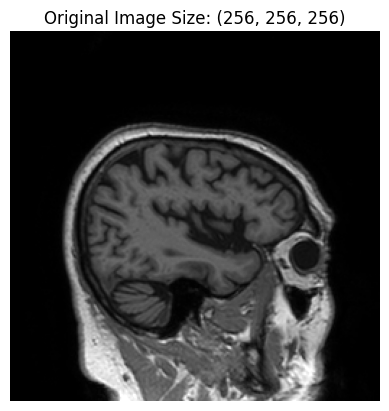

In [14]:
img_nifti = nib.load(adni['processed_path'][34])
img_data = img_nifti.get_fdata()
print(img_data.shape)



# Original image
# index-1: saggital
# index-2 : Axial
# index-3: Coronal
plt.imshow(img_data[85, :, :], cmap='gray')
plt.title(f'Original Image Size: {img_data.shape}')
plt.axis('off')
plt.show()

In [15]:
# start = img_data.shape[2]//3+6
# end = ((img_data.shape[2]//3)*2)-10
# print(start, end)

# MAsked

In [16]:
output_dir = 'axial_masked/'
os.makedirs(output_dir, exist_ok=True)

In [17]:

for value, row in tqdm(adni.iterrows(), total=adni.shape[0]):
    path = row['processed_path']
    img_nifti = nib.load(path)
    img_data = img_nifti.get_fdata()
    
    mask_path = row['mask_path']
    mask_nifti = nib.load(mask_path)
    mask_data = mask_nifti.get_fdata()
    
    
    
    
    start = (img_data.shape[1]//8)*3
    end = start+ 20 #((img_data.shape[2]//3)*2)-10
#     start =85
#     end = 115
    for i in range(start, end):
        image = img_data[:, i, :]
        mask = mask_data[:, i, :]
        # masked ===============================================
        _, binary_mask = cv2.threshold(mask, 0, 1, cv2.THRESH_BINARY)
        smoothed_mask = cv2.bilateralFilter(binary_mask.astype(np.float32), d=10, sigmaColor=75, sigmaSpace=75)

        # Separate masked region
        masked_region = image * smoothed_mask
        
        kernel = np.array([[0, 0, 0],
                   [-5, 20, -5],
                   [0, 0, 0]])


#         image_sharp_2d = cv2.filter2D(src=masked_region, ddepth=-2, kernel=kernel)

#         rescaled = (np.maximum(image_sharp_2d, 0) / image_sharp_2d.max()) * 255
        rescaled = (np.maximum(masked_region, 0) / masked_region.max()) * 255


        final = np.uint8(rescaled)
        final_image = Image.fromarray(final)
    
    
        parts = path.split('/')
        file_name = row['study_id']+'_' +str(i)
    


        output_dir_path = os.path.join(output_dir, row['label'])
    
  
        os.makedirs(output_dir_path, exist_ok=True)


        output_jpg = os.path.join(output_dir_path, f"{file_name}.jpg")

        final_image.save(output_jpg)
    

100%|██████████| 643/643 [06:06<00:00,  1.75it/s]


In [18]:
# import cv2
# image = cv2.imread('/kaggle/working/saggital_processed/CN/I118686_161.jpg')
# plt.imshow(image)
# image.shape

In [19]:
import shutil
shutil.make_archive('axial_masked', 'zip', '/kaggle/working/axial_masked/')

'/kaggle/working/axial_masked.zip'

# Without masked

In [20]:

output_dir_without_masked = 'axial/'
os.makedirs(output_dir_without_masked, exist_ok=True)

for value, row in tqdm(adni.iterrows(), total=adni.shape[0]):
    path = row['processed_path']
    img_nifti = nib.load(path)
    img_data = img_nifti.get_fdata()
    
    # mask_path = row['mask_path']
    # mask_nifti = nib.load(mask_path)
    # mask_data = mask_nifti.get_fdata()
    
    
    
    
    start = (img_data.shape[1]//8)*3
    end = start+ 20 #((img_data.shape[2]//3)*2)-10
#     start =85
#     end = 115
    for i in range(start, end):
        image = img_data[:, i, :]
        


        rescaled = (np.maximum(image, 0) / image.max()) * 255

        final = np.uint8(rescaled)
        final_image = Image.fromarray(final)
    
    
        parts = path.split('/')
        file_name = row['study_id']+'_' +str(i)
    


        output_dir_without_masked_path = os.path.join(output_dir_without_masked, row['label'])
    
  
        os.makedirs(output_dir_without_masked_path, exist_ok=True)


        output_jpg = os.path.join(output_dir_without_masked_path, f"{file_name}.jpg")

        final_image.save(output_jpg)
    

100%|██████████| 643/643 [02:56<00:00,  3.65it/s]


In [21]:
# import cv2
# image = cv2.imread('/kaggle/working/saggital_processed/CN/I118686_161.jpg')
# plt.imshow(image)
# image.shape

In [22]:
import shutil
shutil.make_archive('axial', 'zip', '/kaggle/working/axial/')

'/kaggle/working/axial.zip'